In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("quora_duplicate_questions.tsv", sep="\t")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.dropna(inplace=True)

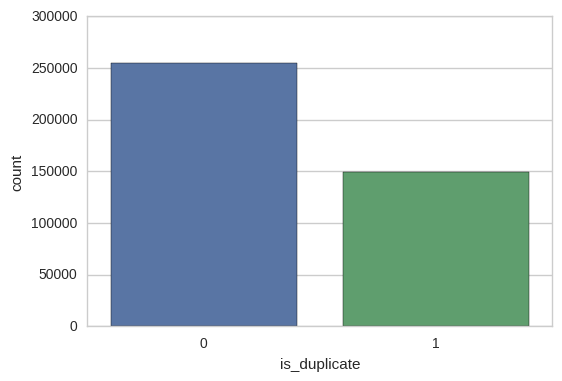

In [5]:
sns.countplot(df["is_duplicate"])

In [6]:
import re

def replace_math(text):
    return re.sub(r"\[math\].*?\[\/math\]","",text)

def replace_code(text):
    return re.sub(r"\[code\].*?\[\/code\]","",text)

df["question1"] = df["question1"].apply(replace_math)
df["question2"] = df["question2"].apply(replace_math)


df["question1"] = df["question1"].apply(replace_code)
df["question2"] = df["question2"].apply(replace_code)

In [7]:
def remove_non_alphabets(text):
    return re.sub(r"[^a-zA-Z\s]",r"",text)

In [8]:
df["question1"] = df["question1"].apply(remove_non_alphabets)
df["question2"] = df["question2"].apply(remove_non_alphabets)

In [9]:
positives = df[df["is_duplicate"]==1]
negatives = df[df["is_duplicate"]==0]

In [10]:
df.shape

(404288, 6)

In [11]:
df.to_csv("quora_full.tsv", sep="\t", index=None)

In [12]:
df = pd.concat([positives,negatives])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404288 entries, 5 to 404289
Data columns (total 6 columns):
id              404288 non-null int64
qid1            404288 non-null int64
qid2            404288 non-null int64
question1       404288 non-null object
question2       404288 non-null object
is_duplicate    404288 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [13]:
df_new = pd.DataFrame(np.hstack([df["question1"].values,df["question2"].values]), columns=["question"])

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808576 entries, 0 to 808575
Data columns (total 1 columns):
question    808576 non-null object
dtypes: object(1)
memory usage: 6.2+ MB


In [15]:
df_new.head()

,question
0,Astrology I am a Capricorn Sun Cap moon and ca...
1,How can I be a good geologist
2,How do I read and find my YouTube comments
3,What can make Physics easy to learn
4,What was your first sexual experience like


In [16]:
df_new["qid"] = np.hstack([df["qid1"].values,df["qid2"].values])

In [17]:
df_new.head()

,question,qid
0,Astrology I am a Capricorn Sun Cap moon and ca...,11
1,How can I be a good geologist,15
2,How do I read and find my YouTube comments,23
3,What can make Physics easy to learn,25
4,What was your first sexual experience like,27


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

In [20]:
tfidf_vectorizer.fit(df_new["question"])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
len(tfidf_vectorizer.vocabulary_)

97636

In [22]:
tfidf_vectorizer.transform(df_new["question"])

<808576x97636 sparse matrix of type '<type 'numpy.float64'>'
	with 3979207 stored elements in Compressed Sparse Row format>

In [23]:
from scipy.sparse import hstack

In [24]:
features = hstack([tfidf_vectorizer.transform(df["question1"]), 
                   tfidf_vectorizer.transform(df["question2"])])

In [25]:
features

<404288x195272 sparse matrix of type '<type 'numpy.float64'>'
	with 3979207 stored elements in COOrdinate format>

In [26]:
X = features.tocsr()
Y = df["is_duplicate"]

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [28]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)
models = {}
models["logistic"] = LogisticRegression()
models["logistic"].fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
print classification_report(Y_test,models["logistic"].predict(X_test))

             precision    recall  f1-score   support

          0       0.77      0.87      0.82     63582
          1       0.72      0.56      0.63     37490

avg / total       0.75      0.75      0.75    101072



In [30]:
from sklearn.cross_validation import StratifiedKFold

In [31]:
kfold = StratifiedKFold(Y_train,n_folds=10,random_state=1)
scores = []
#loop through each fold and calculate class distribution and accuracy
for k,(train,test) in enumerate(kfold):
    model.fit(X_train[train],Y_train[train])
    score = model.score(X_train[test],Y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(Y_train[train]), score))

NameError: name 'pipe_lr' is not defined